# Introduction to the Project

A Project using `tensorflow` to classify a picture of a house into one of 5 classes. 

### Importing the dataset from kaggle to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

After seeing that the data has been split into train, test and validation sets, we then attempt to visualize some of the data

In [ ]:
train_dir = "/content/gdrive/MyDrive/Kaggle/output/train"
test_dir = "/content/gdrive/MyDrive/Kaggle/output/test"
val_dir = "/content/gdrive/MyDrive/Kaggle/output/val"

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path(test_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Bathroom' 'Bedroom' 'Dinning' 'Kitchen' 'Livingroom']


### Visualize the data

In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Set the target directory (view images from the folder)
  target_folder = target_dir + "/" + target_class

  # Get random image
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  #Read in the image and plot it 
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  
  print(f"Image shape: {img.shape}")

  return img

['bed_653.jpg']
Image shape: (224, 224, 3)


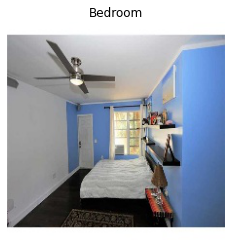

In [ ]:
import random 
img = view_random_image(target_dir = train_dir,
                        target_class = random.choice(class_names))

### Creating Data Loaders to prepare the data

Using `ImageDataGenerator` class to load in the images in batches 

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Load in the images from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               target_size = (224,224),
                                               class_mode = "categorical",
                                               batch_size = 32)

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               target_size = (224,224),
                                               class_mode = "categorical",
                                               batch_size = 32)

Found 4198 images belonging to 5 classes.
Found 530 images belonging to 5 classes.


## Creating a model 
A CNN


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [ ]:
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(5, activation='softmax') 
])

# Compile the model
model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
132/132 [==============================] - 2774s 21s/step - loss: 1.5094 - accuracy: 0.2887 - val_loss: 1.4646 - val_accuracy: 0.3528
Epoch 2/5
132/132 [==============================] - 20s 149ms/step - loss: 1.3334 - accuracy: 0.4378 - val_loss: 1.3805 - val_accuracy: 0.4038
Epoch 3/5
132/132 [==============================] - 20s 149ms/step - loss: 1.0608 - accuracy: 0.5791 - val_loss: 1.3957 - val_accuracy: 0.4340
Epoch 4/5
132/132 [==============================] - 20s 147ms/step - loss: 0.7223 - accuracy: 0.7303 - val_loss: 1.4938 - val_accuracy: 0.4736
Epoch 5/5
132/132 [==============================] - 20s 148ms/step - loss: 0.3614 - accuracy: 0.8797 - val_loss: 1.7725 - val_accuracy: 0.4698


After training a model, it helps to visualize the metrics gotten to get a better idea of what has gone on under the hood of the training that has just been done.

In [ ]:
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

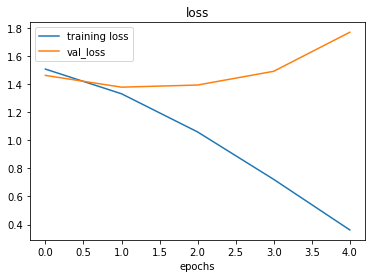

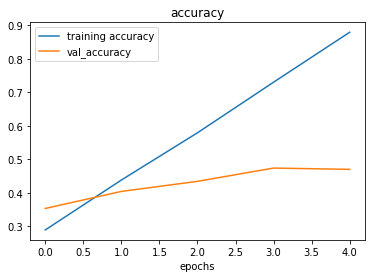

In [ ]:
plot_loss_curves(history_1)

From the visualization, it seems that the data is overfitting. You can see that by the validation accuracy remaining steady while the training accuracy gets better. This simply means that the model is working well on predicting the data from the training dataset but works poorly on data it has not seen before.

Next, we peek under the hood of our model and see what we can do to make it better.

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
model_2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(5, activation='softmax') 
])

# Compile the model
model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Despite the reduction of the number of layers to reduce overfitting, it seems there are still problems with the data in that sense. Next, another step is taken to try and improve the model which is data augmentation

## Data Augmentation

At this point, we use data augmentation to see if it possible to beat the baseline that has been established earlier

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 4198 images belonging to 5 classes.
Non-augmented training images:
Found 4198 images belonging to 5 classes.
Unchanged test images:
Found 530 images belonging to 5 classes.


In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

In [ ]:
len(test_data), len(train_data)

(17, 132)

In [ ]:
# Show original image and augmented image
import random
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

After successfully augmenting the data, we then train the last model used on this data to see how the model performs

In [ ]:
model_3 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(5, activation='softmax') 
])

# Compile the model
model_3.compile(loss="sparse_categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
132/132 [==============================] - 67s 502ms/step - loss: 1.6316 - accuracy: 0.2037 - val_loss: 1.5475 - val_accuracy: 0.2849
Epoch 2/5
132/132 [==============================] - 66s 503ms/step - loss: 1.5712 - accuracy: 0.1946 - val_loss: 1.5507 - val_accuracy: 0.2226
Epoch 3/5
132/132 [==============================] - 66s 496ms/step - loss: 1.5516 - accuracy: 0.2518 - val_loss: 1.5196 - val_accuracy: 0.2208
Epoch 4/5
132/132 [==============================] - 65s 495ms/step - loss: 1.5483 - accuracy: 0.2265 - val_loss: 1.5309 - val_accuracy: 0.2415
Epoch 5/5
132/132 [==============================] - 65s 493ms/step - loss: 1.5621 - accuracy: 0.2699 - val_loss: 1.5149 - val_accuracy: 0.2660


It is quite obvious that Data Augmentation didn't work, it even made the model worse and that's something to be looked into. We take our last successful model and work on reducing the overfitting and then working from there onward.

In [ ]:
model_4 = Sequential([
  Conv2D(100, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2),
  Conv2D(100, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(5, activation='softmax') 
])

# Compile the model
model_4.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
132/132 [==============================] - 2858s 22s/step - loss: 1.6578 - accuracy: 0.3044 - val_loss: 1.4494 - val_accuracy: 0.3585
Epoch 2/5
132/132 [==============================] - 34s 259ms/step - loss: 1.2310 - accuracy: 0.5017 - val_loss: 1.4349 - val_accuracy: 0.4113
Epoch 3/5
132/132 [==============================] - 34s 260ms/step - loss: 0.8510 - accuracy: 0.6879 - val_loss: 1.6352 - val_accuracy: 0.4038
Epoch 4/5
132/132 [==============================] - 35s 261ms/step - loss: 0.4718 - accuracy: 0.8354 - val_loss: 1.7844 - val_accuracy: 0.4245
Epoch 5/5
132/132 [==============================] - 34s 260ms/step - loss: 0.2247 - accuracy: 0.9376 - val_loss: 2.3900 - val_accuracy: 0.4340


Increasing the layers didn't do anything major to improve the model. Next attempt is going to be on transfer learning

In [ ]:
# Comparing two models 

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape. The +3 is just another way of defining (224,224,3)
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                             num_classes=train_data.num_classes)

In [ ]:
# Compile resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
#Fitting ResNet model to the data 
resnet_history = resnet_model.fit(train_data,
                             epochs=5,
                             steps_per_epoch=len(train_data),
                             validation_data = test_data,
                             validation_steps = len(test_data))

Epoch 1/5
 71/132 [===============>..............] - ETA: 17:53 - loss: 0.8650 - accuracy: 0.6790

In [ ]:
resnet_model.save("Resnet_Model_format")

In [ ]:
resnet_model.save("Resnet_model.h5")

In [ ]:
my_reloaded_model = tf.keras.models.load_model(("/content/Resnet_model.h5"),custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
my_reloaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
def load_and_prep_image(filename, img_shape=224):

  """
  Reads an image from filename, turns it to a tensor and reshapes it 
  to (img_shape, img_shape, colour_channels)
  """
  
  # Read in the image 
  img = tf.io.read_file(filename)
  # Decord the read file into a tensor 
  img = tf.image.decode_image(img)
  #Resize the image 
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values standardized)
  img = img/255.
  return img 

In [ ]:
def pred_and_plot (model, filename, class_names = class_names):
  """
  Imports an image located at filename, makes a prediction with the model specified
  and plot the image with the predicted class at the title
  """

  # Import the target image and preprocess it 
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[(int(tf.round(pred)))]

  # Get the predicted class
  # pred_class = class_names[(int(tf.round(pred)))]

  #P Plot the image and predicted class 
  plt.imshow(img)
  plt.title(f"Prediction:{pred_class}")
  plt.axis(False);

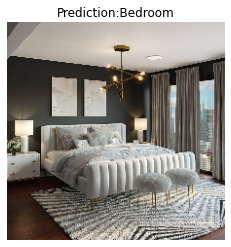

In [ ]:
pred_and_plot(model=my_reloaded_model, filename="bed.jpeg",
              class_names = class_names)

In [ ]:
print(class_names)

['Bathroom' 'Bedroom' 'Dinning' 'Kitchen' 'Livingroom']


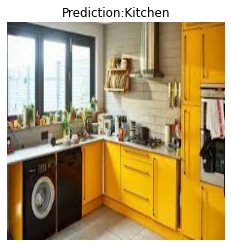

In [ ]:
pred_and_plot(model=my_reloaded_model, filename="kit.jpeg",
              class_names = class_names)

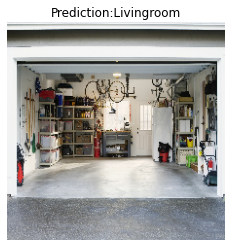

In [ ]:
pred_and_plot(model=my_reloaded_model, filename="gar.jpeg",
              class_names = class_names)